# Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from skimage.io import imread, imshow
from skimage import transform, img_as_float
import glob
import math

In [2]:
cwd = os.getcwd()
path = os.path.join(cwd, '..', 'src')
if not path in sys.path:
    sys.path.append(path)
del cwd, path

In [3]:
import KaggleAmazonMain as kam

In [10]:
X_train, y_train, names_train, tagged_df = kam.load_training_data()

cwd C:\Work\Kaggle\Planet\kaggle_UnderstandingAmazonFromSpace\develop
Loading jpg image dataset


In [11]:
tagged_df.head()

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
image_name,,,,,,,,,,,,,,,,,
train_0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
train_1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
train_10,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1
train_100,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
train_1000,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0


There are 17 unique tags in this data


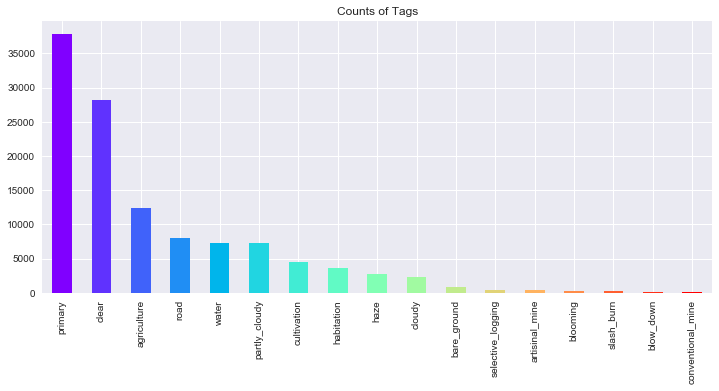

primary              37840
clear                28203
agriculture          12338
road                  8076
water                 7262
partly_cloudy         7251
cultivation           4547
habitation            3662
haze                  2695
cloudy                2330
bare_ground            859
selective_logging      340
artisinal_mine         339
blooming               332
slash_burn             209
blow_down              101
conventional_mine      100
dtype: int64

In [12]:
#Barplot of tag counts
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 5)
print('There are {} unique tags in this data'.format(len(tagged_df.columns)))
colors = cm.rainbow(np.linspace(0, 1, len(tagged_df.columns)))
tagged_df.sum().sort_values(ascending=False).plot(title="Counts of Tags", color=colors, kind='bar')
plt.show()
tagged_df.sum().sort_values(ascending=False)

In [16]:
# 100 files, images are 256x256 pixels, with a channel dimension size 3 = RGB
print('X_train is a {} object'.format(type(X_train)))
print('it has shape {}'.format(X_train.shape))

print('y_train is a {} object'.format(type(y_train)))
print('it has {} elements'.format(len(y_train)))
print('each element is of type {}'.format(type(y_train[0])))
print('and the elements are of size {}'.format(y_train[0].shape))

print('names_train is a {} object'.format(type(names_train)))
print('it has {} elements'.format(len(names_train)))
print('each element is of type {}'.format(type(names_train)))

X_train is a <class 'numpy.ndarray'> object
it has shape (100, 256, 256, 3)
y_train is a <class 'list'> object
it has 100 elements
each element is of type <class 'pandas.core.series.Series'>
and the elements are of size (17,)
names_train is a <class 'list'> object
it has 100 elements
each element is of type <class 'list'>


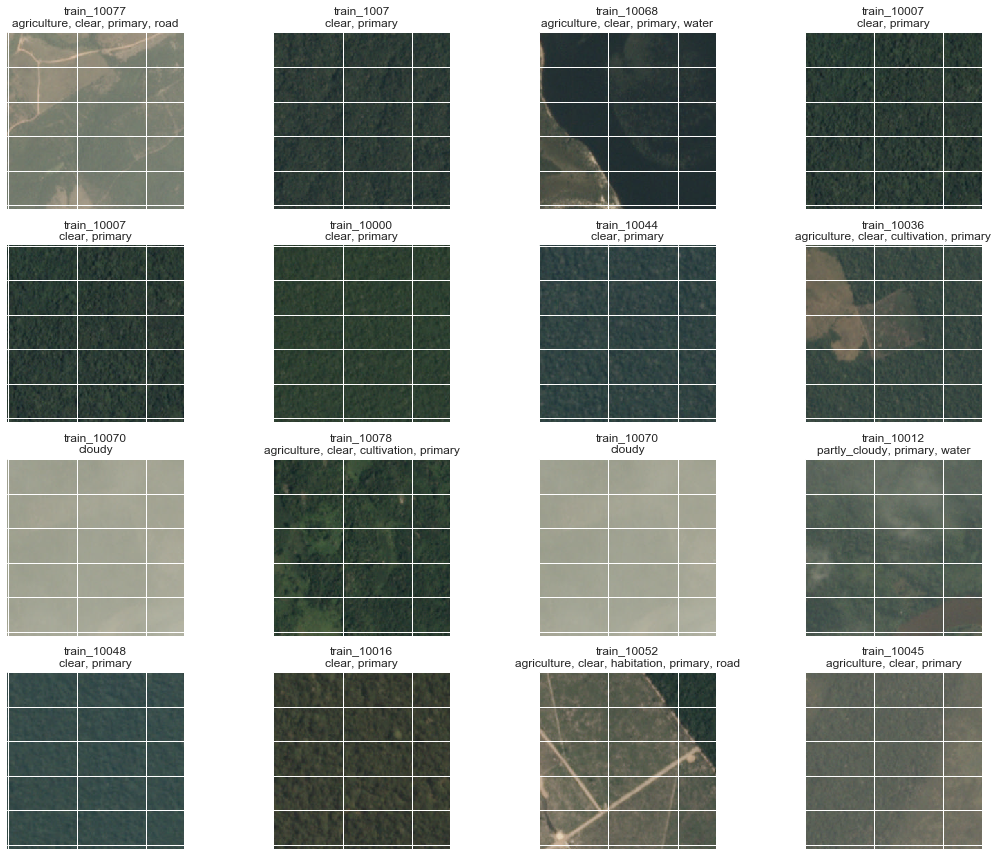

In [20]:
kam.plot_samples(X_train, names_train, tagged_df, nrow=4, ncol=4)

# Feature Engineering
What type of features are we working with here?
Feature engineering explores the feature data, and does feature creation.
Each image consists of pixel values in red, geen, and blue color schemes. The patterns in these pixels will  have useful trends for classifying the objects in the images and the image types. Notice how the statistical distributions of the red, green, and blue, pixels differ for different types of tags.

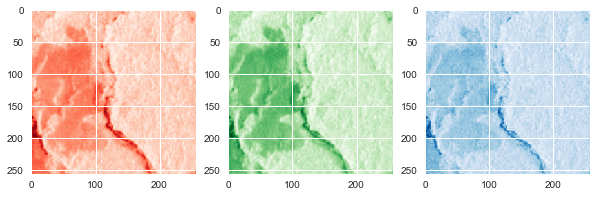

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(10, 6))
axes[0].imshow(X_train[1,:,:,0], cmap='Reds')
axes[1].imshow(X_train[1,:,:,1], cmap='Greens')
axes[2].imshow(X_train[1,:,:,2], cmap='Blues')

C:\Users\clongo\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


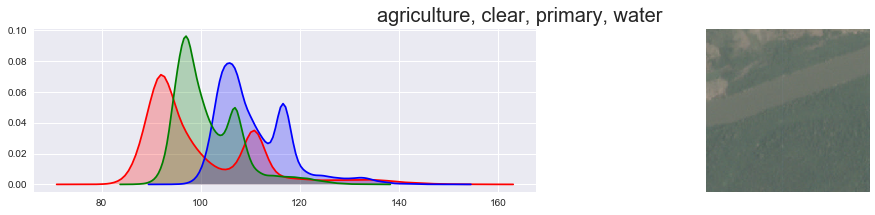

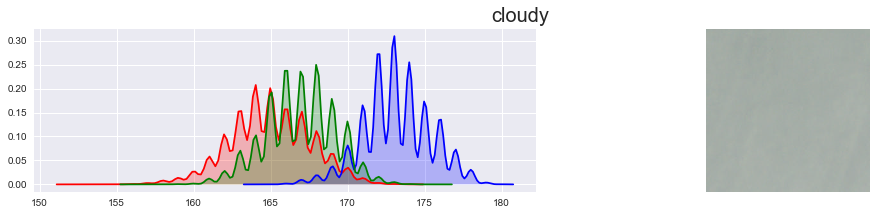

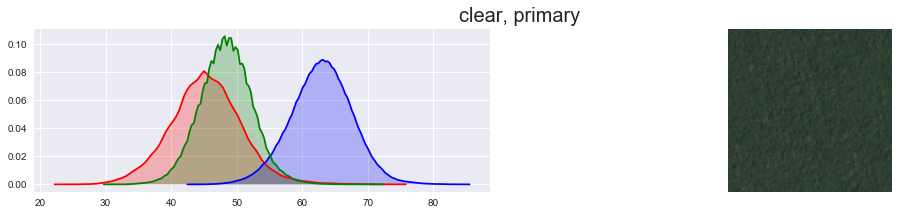

In [40]:
plt.subplots_adjust(wspace=0, hspace=0)
for i in range(0,3):
    sample = np.random.randint(low=0, high=X_train.shape[0]-1, size = 1)
    ind = names_train[sample[0]]
    tags = kam.get_labels(ind, tagged_df)
    kam.plot_rgb_dist(X_train[sample[0],:,:,:],tags)

## Feature Creation
Create features from the raw pixel data. These metrics should be metrics that describe patterns in the trends and distributions of the pixels. 
Using binned historgram features to capture bimodality and general shape and location of distributions in red, green, and blue.